# APPENDIX A

## Procedure
1.  Normalize the features of the input data by using the standard (sample-minimum) / (maximum - minimum) function.  This distributes the feature values between 0 and 1
2.  Build a custom Single Hidden Layer Neural Network (SHLNN) that includes the following options: data split into training and test groups, learningRate, momentum, epochs and random seed.
    1.  Append the bias to the sample set data
    2.  Create weight arrays to represent the connections between the input nodes and the hidden layer, and the hidden layer and the output
    3.  Run the SHLNN using stochastic gradient descent (STD), updating weights through backpropagation after each training instance
3.  Test the SHLNN on the iris dataset
4.  Modify parameters and hyper-parameters to maximize speed and accuracy
5.  Compare results to SKLearn MLNN


## Import dataset and normalize features

In [167]:
from sklearn import datasets
import numpy as np

def normalizeFeatureInput(samples):
    """
    parameters: 2D array containing samples
    return: array of identical shape conntaining normalized values
    between 0 and 1
    """
    arr = np.array(samples)
    minimum = np.amin(arr.T, axis = 1)
    maximum = np.amax(arr.T, axis = 1)
    
    newArr = []
    for sample in arr:
        newArr.append((sample - minimum) / (maximum - minimum))
    
    return np.array(newArr)

iris = datasets.load_iris()
samples = iris.data
targets = iris.target
nd = normalizeFeatureInput(samples)


## NN object with .fit, .score, .printLog API

In [169]:
class MLNN(object):
    
    def __init__(self, split = 0.75, learningRate = 0.1, momentum = 0.1, epochs = 500, seed = 1, shuffle = True, SGD_size = 1):
        self.split = split
        self.learningRate = learningRate
        self.momentum = momentum
        self.epochs = epochs
        self.seed = seed
        self.SGD_size = SGD_size
        self.bestModel = []
        
    
    def fit(self, samples, targets, h_nodes = 8):
        self.x = np.array(samples)
        self.y = np.zeros((samples.shape[0], np.unique(targets).shape[0]))
        self.h_nodes = h_nodes
        self.cost = []
        epochCost = []
        self.trainingScore = []
        self.testScore = []        
        d_ow = []
        d_hw = []
        rand = np.random.RandomState(self.seed)
        #convert output classes to probabilities
        for i in range(len(targets)):
            self.y[i][targets[i]] = 1

        #create the bias weights for each layer
        bias = np.full((self.x.shape[0],1),1)
        bias_hidden = 1.
        bias_output = 1.

        #create the hidden layer
        hidden = np.zeros((1,self.h_nodes))

        #create the weight arrays
        self.inputWeights = rand.normal(loc=0.0, 
                                        scale = 0.1, 
                                        size = (self.x.shape[1], 
                                                hidden.shape[1]))
        self.outputWeights = rand.normal(loc=0.0, 
                                         scale = 0.1, 
                                         size = (hidden.shape[1], 
                                                 np.unique(targets).shape[0]))

        #shuffle indices
        indices = np.arange(self.x.shape[0])
        rand.shuffle(indices)
        self.training, self.test = self.splitTrainingSet(indices)

        for epoch in range(self.epochs):
            rand.shuffle(self.training)

            for i in self.training:
                #forward propagation
                hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
                sighidden = self.sigmoid(hidden)
                output = sighidden.dot(self.outputWeights) #+ bias_output
                sigout = self.sigmoid(output)
                yhat = self.oneHotEncode(sigout)


                #compute delta rule on output and input weights            
                #partial derivative of Etotal v yHat
                d_e_yhat = sigout - self.y[i]

                epochCost.append((.5*(d_e_yhat)**2).sum())

                #partial derivative of yhat v y (output node output vs input)
                d_yhat_y = self.sigmoidDerivative(sigout)

                #partial derivative of y v outputweights
                d_y_ow = sighidden
                d_e_y = d_e_yhat * d_yhat_y
                #output weights error, reshaping the arrays in order to perform the calculation
                deltaOut = d_y_ow.reshape((-1,1))*(d_e_yhat * d_yhat_y).reshape((1,-1))
                deltaHidden = (self.outputWeights.dot(d_e_y.reshape((-1,1)))*self.sigmoidDerivative(sighidden).reshape((-1,1))*self.x[i]).T


                #change in outputweights: array where each element is how much each node weight should change ( weights connected to hidden node)
                weightOutError = self.learningRate*deltaOut
                weightInError = self.learningRate*deltaHidden

                #track error updates for momentum
                d_ow.append(weightOutError)
                d_hw.append(weightInError)

                #update output weights
                self.outputWeights -= weightOutError + self.momentum*d_ow[-1]
                self.inputWeights -= weightInError + self.momentum*d_hw[-1]
            self.cost.append(sum(epochCost))
            epochCost.clear()
            self.internalScore()
            if not self.progress():
                return self
        return self
    
    def splitTrainingSet(self, inputvalues):
        """
        Assumes the data is already randomized
        returns two lists of indices"""
        length =  inputvalues.shape[0]
        train = int(length*self.split)
        return (inputvalues[:train], inputvalues[train:])
    
    def oneHotEncode(self, outputs):
        """
        parameter: output array (1D)
        Return: one hot encoded output based on max value. 
        e.g [.2, .4, .6] would be encoded as [0, 0, 1]
        """
        i = np.argmax(outputs)
        new = np.zeros(outputs.shape[0])
        new[i] = 1
        return new
    
    def sigmoid(self, inputLayer):
        """
        parameter: list of values
        return: sigmoid(list) as numpy array
        """
        return np.array([1 / (1 + np.exp(-item)) for item in inputLayer])

    def sigmoidDerivative(self, sigmoid):
        """
        parameter: list of sigmoid activation values
        return : numpy array of sigmoid derivative"""
        return np.array([ item * (1 - item) for item in sigmoid])
    
    def internalScore(self):
        correct = 0
        for i in self.training:
            hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            if np.array_equal(yhat, self.y[i]):
                correct = correct + 1 
        self.trainingScore.append(correct / float(self.training.shape[0]))
        
        correct = 0
        for i in self.test:
            hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            if np.array_equal(yhat, self.y[i]):
                correct = correct + 1
        self.testScore.append(correct / float(self.test.shape[0]))
        return 
    
    def score(self, X, y):
        correct = 0
        out = np.zeros((X.shape[0],np.argmax(y)+1))
        for i in range(len(y)):
            out[i][y[i]] = 1
        for i in range(len(X)):
            hidden = X[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            if np.array_equal(yhat, out[i]):
                correct = correct + 1 
        return correct / float(X.shape[0])
        
    def progress(self):
        #checks the progress of model creation.  Returns true if progress is being made and false if the creation process should end
        #if best score, save the model
        if self.testScore[-1] == np.amax(self.testScore):
            self.storeModel()
            if self.testScore[-1] == 1.0:
                return False
            return True
        if len(self.testScore) >= int(0.2*self.epochs):
            #less than average of last ten - did we already max out, and now decreasing? 
            #Or is this just a local minimum that must be pushed through? Restore best model and quit
            if np.average(self.cost[len(self.cost)-5:]) < self.cost[-1]:
                self.restoreModel()
                return False
            #greater than average of last ten - continue forward, we're making progress, do nothing
            elif np.average(self.cost[len(self.cost)-5:]) > self.cost[-1]:
                return True
            #testscore is perfect

        else:
            return True
                              
    def storeModel(self):
        #store the current model to the best model list
        self.bestModel.append([self.inputWeights, self.outputWeights])
        
    def restoreModel(self):
        #restore the best model to the current model
        self.inputWeights = self.bestModel[-1][0]
        self.outputWeights = self.bestModel[-1][1]
    
    def printLog(self):
        from datetime import datetime
    
        log = open(f"log_LR_{self.learningRate}_Epoch_{self.epochs}_Momentum_{self.momentum}_Hidden_{self.h_nodes}.txt","w")
        log.write(f'Paramters: Learning Rate: {self.learningRate}  Epochs: {self.epochs}  Momentum: {self.momentum}  Training Split {self.split} Hidden: {self.h_nodes}\n')
        log.write(f'{datetime.now()}\n')    
        log.write("Training Results:\n")
        correct = 0
        for i in self.training:
            hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            result = False
            if np.array_equal(yhat, self.y[i]):
                result = True
                correct = correct + 1
            log.write(f'{i} Predicted:{self.oneHotEncode(sigout)} -- {result}\n')
        log.write(f'Percentage: {correct / float(self.training.shape[0])}\n')
        log.write(f'Correct: {correct}, Total: {self.training.shape[0]}\n\n')
        
        log.write("TEST Results:\n")
        correct = 0
        for i in self.test:
            hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            result = False
            if np.array_equal(yhat, self.y[i]):
                result = True
                correct = correct + 1
            log.write(f'{i} Predicted:{self.oneHotEncode(sigout)} -- {result}\n')
        log.write(f'Percentage: {correct / float(self.test.shape[0])}\n')
        log.write(f'Correct: {correct}, Total: {self.test.shape[0]}\n\n')
        
        log.write("Complete Set Results:\n")
        correct = 0
        for i in range(self.x.shape[0]):
            hidden = self.x[i].dot(self.inputWeights) #+ bias_hidden
            sighidden = self.sigmoid(hidden)
            output = sighidden.dot(self.outputWeights) #+ bias_output
            sigout = self.sigmoid(output)
            yhat = self.oneHotEncode(sigout)
            result = False
            if np.array_equal(yhat, self.y[i]):
                result = True
                correct = correct + 1
            log.write(f'{i} Predicted:{self.oneHotEncode(sigout)} -- {result}\n')
        log.write(f'Percentage: {correct / float(self.x.shape[0])}\n')
        log.write(f'Correct: {correct}, Total: {self.x.shape[0]}\n\n')
            
        
        log.write(f'Cost:{self.cost[-1]}\n')
        

## Testing Model Creation

In [174]:
NN = MLNN(learningRate = 0.6, momentum = 0.1, epochs = 100, seed=1)
NN.fit(nd, targets, h_nodes = 8)
#NN.printLog()
for i in range(len(NN.testScore)):
    print(f'epoch: {i}, test score: {NN.testScore[i]}')


epoch: 0, test score: 0.2894736842105263
epoch: 1, test score: 0.2631578947368421
epoch: 2, test score: 0.7631578947368421
epoch: 3, test score: 0.5526315789473685
epoch: 4, test score: 0.9736842105263158
epoch: 5, test score: 0.9736842105263158
epoch: 6, test score: 0.9736842105263158
epoch: 7, test score: 0.7105263157894737
epoch: 8, test score: 0.5526315789473685
epoch: 9, test score: 0.9736842105263158
epoch: 10, test score: 0.7368421052631579
epoch: 11, test score: 0.9473684210526315
epoch: 12, test score: 0.9210526315789473
epoch: 13, test score: 0.6842105263157895
epoch: 14, test score: 0.9736842105263158
epoch: 15, test score: 0.9473684210526315
epoch: 16, test score: 0.9473684210526315
epoch: 17, test score: 0.9473684210526315
epoch: 18, test score: 0.9473684210526315
epoch: 19, test score: 0.9473684210526315
epoch: 20, test score: 1.0


## Running on new test set

In [176]:
print(NN.score(X_test,y_test))


0.9736842105263158


## Figure creation example

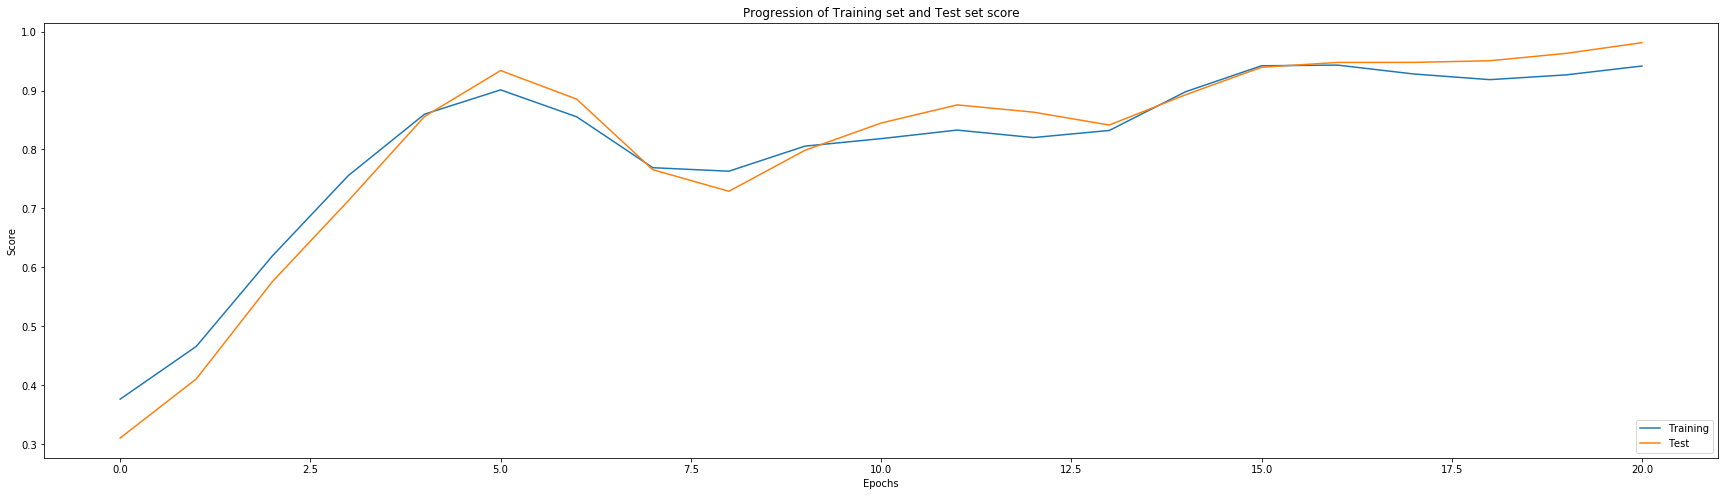

In [177]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

train_smoothed = gaussian_filter1d(NN.trainingScore, sigma=1)
test_smoothed = gaussian_filter1d(NN.testScore, sigma=1)
plt.figure(figsize=(30,8))
#plt.plot(NN.trainingScore, label = "Training")
#plt.plot(NN.testScore, label = "Test")
plt.plot(train_smoothed, label = "Training")
plt.plot(test_smoothed, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Progression of Training set and Test set score")
plt.legend(loc='lower right')
plt.show()

## Log Creation

In [178]:
#use this to create output logs
nodes = []
sse = []
i = 2
for x in range(i,129, i*2):
    TestNN = MLNN(learningRate = 0.6, epochs = 500, momentum = 0.1)
    TestNN.fit(nd,targets, h_nodes = x)
    nodes.append(x)
    sse.append(TestNN.cost)
    TestNN.printLog()



## Compare to SKLearn

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    nd, targets, test_size=0.25, random_state=42)
skNN = MLPClassifier(activation = "logistic", 
                     solver='sgd',
                     learning_rate_init = 0.1,
                     learning_rate = "constant",
                     momentum = 0.1,
                     max_iter = 10000
                    )
skNN.fit(X_train, y_train)

In [164]:
print(f'skLearn Training Score: {skNN.score(X_train, y_train)}')
print(f'skLearn Test Score: {skNN.score(X_test, y_test)}')

skLearn Training Score: 0.9553571428571429
skLearn Test Score: 1.0
